N= 637
timescale of decay to fixed point: 0.6647303544280019
max real eigenval of jac: -1.0630851172659446
Time to generate x(t): 0.5088131427764893 s
Time for sim: 30.27276921272278 s
z min, zmax 0.06114186598313655 0.8418180009647079
Time for PCA calc: 1.2322781085968018


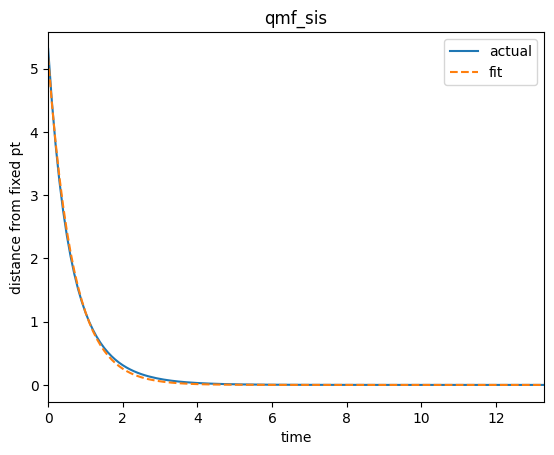

In [1]:
# Adapted from 
# @author: Vincent Thibeault

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from low_rank_hypothesis import qmf_sis_pert, qmf_sis
from scipy.integrate import solve_ivp
from low_rank_hypothesis import jacobian_x_SIS, jacobian_y_SIS
from low_rank_hypothesis import get_epidemiological_weight_matrix
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA
import torch
from time import time as tm

# Save figures?
SaveFigs=True



device='cpu'

integration_method = 'RK23'
rtol = 1e1#1e-4
atol = 1e1#1e-6

dt=0.1


def jacobian_complete(x, W, coupling, D):
    Jx = jacobian_x_SIS(x, W, coupling, D)
    Jy = jacobian_y_SIS(x, coupling)
    return Jx + Jy@W




### Graph parameters 
graph_str = "high_school_proximity"
A = get_epidemiological_weight_matrix(graph_str)
N = len(A[0])  # Dimension of the complete dynamics


### Dynamical parameters
# dynamics_str = "qmf_sis"
D = np.eye(N)
#coupling_constants = np.linspace(0.01, 4, 1000)
# coupling_constants = np.linspace(0.9, 1.1, 50)
# ^ near bifurcation
coupling = 3
print('N=',N)

# SVD of connectivity
U,S,VT = np.linalg.svd(A)
V=VT.T


# Normalize the network by the largest singular value.
# The coupling parameter determines the overall
# strength of connections.
W = A/S[0]
S = coupling*S/S[0]


# Initial condition
x0 = 0.3*np.random.random(N)+.3

# First solve the system with no perturbation over a shorter time window
# This allows us to estimate fixed points and the timescale of the system
T = 300
t_span = [0, T]
Nt=int(T/dt)
time=np.arange(0,T,dt)


args_dynamics_nopert = (W, coupling, D)
sol_nopert = solve_ivp(qmf_sis, t_span, x0, integration_method,
                args=args_dynamics_nopert, rtol=rtol, atol=atol, max_step=dt,
                vectorized=False)#, jac=jacobian_complete)
z_nopert = sol_nopert.y.T
tc_nopert = sol_nopert.t
z_fp = sol_nopert.y[:,-1]


# Fit the approach towards the fixed point to an exponential decay
# to get an effective time constant
def exp_decay(t, c, tau):
    return c * np.exp(-t/tau)
dist_from_fp = np.linalg.norm(z_nopert-z_fp,axis=1)
cinit = dist_from_fp[0]
tauinit = -tc_nopert[1] / np.log(dist_from_fp[1]/dist_from_fp[0])
par, _ = curve_fit(exp_decay, tc_nopert, dist_from_fp, p0=[cinit, tauinit])
c_fit, tau_fit = par
print('timescale of decay to fixed point:',tau_fit)

plt.figure()
plt.plot(tc_nopert,dist_from_fp,label='actual')
plt.plot(tc_nopert, exp_decay(tc_nopert, c_fit, tau_fit),'--',label='fit')
plt.xlim([0,20*tau_fit])
plt.xlabel('time')
plt.ylabel('distance from fixed pt')
plt.legend()
plt.title('qmf_sis')
plt.savefig('./ScratchFigs/qmf_sis_fit.pdf')

# Compute jacobian at fixed point. Check stability
jac = jacobian_complete(z_fp, W, coupling, D)
lam = np.linalg.eigvals(jac)
print('max real eigenval of jac:',np.real(lam).max())

# Compute singular values of Jacobian, projection vectors
UJ,SJ,VJT = np.linalg.svd(jac)
VJ=VJT.T

# Define projection vectors and matrix
u = UJ[:,0]
v = VJ[:,0]
P = UJ.T@VJ

############
### Now simulate with Gaussian noise input to perform PCA analysis
dt=.2
T = 5000
t_span = [0, T]
Nt=int(T/dt)
time=np.arange(0,T,dt)


# taux should be significantly larger than tau_fit
taux=10
sigmax=.01

# Generate perturbation
with torch.no_grad():
    t0=tm()
    x = sigmax*MakeSmoothGaussianProcess(taux,Nt+1,dt,N,device=device).T
    x = ToNP(x[:,:].float())
    print('Time to generate x(t):',tm()-t0,'s')

# Define perturbation as a function of time.
# This is needed for using the perturbation in the ODE solver.
# It would probably be better to use interpolation here
def xt(t):
    return x[int(t/dt),:]

# Solve the system with a perturbation
t0=tm()
args_dynamics = (W, coupling, D, xt)
sol = solve_ivp(qmf_sis_pert, t_span, x0, integration_method,
                args=args_dynamics, rtol=rtol, atol=atol, max_step=dt,
                vectorized=False)#, jac=jacobian_complete)
ztc = sol.y.T
tc = sol.t
print('Time for sim:',tm()-t0,'s')

# Resample z over the uniform time mesh, time.
z=np.zeros((Nt,N))
for j in range(N):
    z[:,j] = np.interp(time,tc,ztc[:,j])

print('z min, zmax',z.min(),z.max())

# Get a random unit vector
urand = np.random.randn(N)
urand = urand/np.linalg.norm(urand)

# Burn in period
Tburn=10*tau_fit
nburn = int(Tburn/dt)

# Define projected variables as the deviation of the 
# projection from its value at fixed point
zu = z@u
zv = z@v
zurand = z@urand
zu = zu - z_fp@u#zu[nburn:].mean()
zv = zv - z_fp@v#zv[nburn:].mean()
zurand = zurand - z_fp@urand#zurand[nburn:].mean()


# Perform PCA on x and z
t0=tm()
with torch.no_grad():
    Ux,Sx=TorchPCA(torch.tensor(x[nburn:,:]), scaled=True)
    Uz,Sz=TorchPCA(torch.tensor(z[nburn:,:]), scaled=True)
    Ux=ToNP(Ux)
    Sx=ToNP(Sx)
    Uz=ToNP(Uz)
    Sz=ToNP(Sz)
print('Time for PCA calc:',tm()-t0)



done


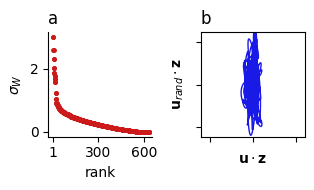

In [2]:

# Make figure

xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]


fig, axes = plt.subplot_mosaic("ab",figsize=(3.25,2))

c0='a'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,S,'.',markersize=5, color=Wclr)
ax0.set_xlim([-30,N+20])
# #ax0.set_yticks([0,.5,1])
ax0.set_xticks([1,300, 600])
ax0.set_xlabel('rank')
ax0.set_ylabel(r'$\sigma_W$')
# #ax0.set_yscale('log')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)



# c0='b'
# ax0 = axes[c0]
# im = ax0.imshow(P[:7,:7], cmap='RdBu', vmin=-1, vmax=1)
# cbar = fig.colorbar(im, ax=ax0)
# cbar.set_ticks([-1,0,1])
# ax0.set_xticks([])
# ax0.set_yticks([])
# ax0.set_ylabel('P')
# ax0.set_title(c0,loc='left')



c0='b'
I2plot=int(2000/dt)
maxabsproj = np.maximum(np.abs(zu[nburn:I2plot]).max(),np.abs(zurand[nburn:I2plot]).max())
ax0 = axes[c0]
ax0.plot((zu[nburn:I2plot]),(zurand[nburn:I2plot]),color=zclr,lw=1)
ax0.axis([-maxabsproj,maxabsproj,-maxabsproj,maxabsproj])
#ax0.set_xticks([-.01,0,.01])
#ax0.set_yticks([-.01,0,.01])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{z}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{z}$')
ax0.set_title(c0,loc='left')


plt.tight_layout()


if SaveFigs:
    fig.savefig('./Figures/SuppFigEpidemiological.pdf')
    fig.savefig('./Figures/SuppFigEpidemiologicalunpolished.svg')



print('done')

